# Chess Analysis Project


Inspired by [other](https://www.kaggle.com/ironicninja/converting-raw-chess-pgn-to-readable-data) [chess](https://github.com/Ramon-Deniz/ChessData#heatmap-of-chess-moves) visualization projects, I decided to do a similar analysis of my own as a data cleaning/visualization practice project. However, to mix things up a little bit and work in some extra practice topics, I opted to create a SQL database instead of parsing and analyzing the data simultaneously. For this project I'll be operating with the January 2016 game files found on the [Lichess database](https://database.lichess.org/) site. Initially I had intended to run the analysis on several months worth of data, but I've put those plans on hold for the time being. We'll see why shortly.


A couple notes before we dive in. First, I will include all code used to create and query the database as well as generate the plots. The code will be nonfunctional in this environment as I won't be uploading the source database, though all data should be reproduceable after downloading the Jan 2016 pgn file. I will provide images where I can't provide executable code. 

Second, I opted for SQLite as my SQL engine. This was because I had a basic level of familiarity with the system after working through the excellent [Python For Everybody](https://www.youtube.com/watch?v=8DvywoWv6fI) course taught by Chuck Severance, and I knew there was a good library for interacting with SQLite available for Python. 

## PGN Parsing and Database Creation

In [49]:
import chess.pgn as pgn
import sqlite3 as sql
import regex as re
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
import json

In [19]:
#First, a look at how the pgn files are structured.

games = open(r'Jan 2016.pgn') 
for x in range(18):
    print(games.readline())
    

[Event "Rated Blitz tournament https://lichess.org/tournament/WyLZ5r0n"]

[Site "https://lichess.org/HoJqFz7k"]

[White "t1r33"]

[Black "mashi"]

[Result "0-1"]

[UTCDate "2015.12.31"]

[UTCTime "23:00:03"]

[WhiteElo "1305"]

[BlackElo "1321"]

[WhiteRatingDiff "-13"]

[BlackRatingDiff "+14"]

[ECO "?"]

[Opening "?"]

[TimeControl "300+0"]

[Termination "Abandoned"]



 0-1





In [13]:
#Each entry records various data about the game as well as the moves themselves. 
#Rather than a custom script, I'm using the 'chess' package to parse these games.

games = open(r'Jan 2016.pgn')

game = pgn.read_game(games)
for x in range(5):
    game=pgn.read_game(games) #The first several games were quickly abandoned
    
print(game.headers) #Game metadata is stored in the headers class

print()

print(game.mainline_moves()) #mainline_moves is an iterable object. Note that the notation style is converted from algebraic to uci.


Headers(Event='Rated Blitz tournament https://lichess.org/tournament/Oqh7ddtQ', Site='https://lichess.org/jmaU6AKT', Date='????.??.??', Round='?', White='Illcross', Black='roquemaspoli', Result='1-0', BlackElo='2080', BlackRatingDiff='-5', ECO='E30', Opening='Nimzo-Indian Defense: Leningrad Variation', Termination='Normal', TimeControl='180+0', UTCDate='2015.12.31', UTCTime='23:00:03', WhiteElo='2339', WhiteRatingDiff='+5')

1. d4 e6 2. c4 Nf6 3. Nc3 Bb4 4. Bg5 h6 5. Bxf6 Qxf6 6. Nf3 O-O 7. e4 Bxc3+ 8. bxc3 d6 9. Bd3 e5 10. h3 c5 11. d5 b6 12. Nh2 Qe7 13. O-O Nd7 14. f4 exf4 15. Rxf4 Ne5 16. Bf1 Ba6 17. Ng4 f6 18. Qe1 Bc8 19. Qg3 Bxg4 20. hxg4 Rf7 21. Be2 Qd7 22. Raf1 Qa4 23. g5 hxg5 24. Rf5 Qxa2 25. Bh5 Rff8 26. Qh3 Qxc4 27. Rxe5 fxe5 28. Qe6+ Kh8 29. Bf7 Qd3 30. Rf3 Qxf3 31. gxf3 g6 32. Qf6+ Kh7 33. Qxg6+ Kh8 34. Qh6#


Now, a quick diversion into database design. The header data will be useful for direct analysis in addition to being used to filter the move data. I'd like to keep the  headers and move data in seperate tables to limit overall table size and hopefully speed up queries as well. The 'Site' field in the header turns out to have a unique 8 character ID at the end of the address that can be used to pull up the game on the Lichess site. It can also serve as a convenient key to link the two tables.

As far as designing the two tables, the header data transfers rather conveniently into database form, however the move data requires some choices to be made. Rather than transcribing moves in order (and having large empty sections due to variable game length), moves are recorded by piece. Games can't be reconstructed this way, but it will be far easier (and faster) to query piece movement and captures for later graphing. 

All that said, SQL table creation statements follow.



---------------------------------------------------------
CREATE TABLE "games_metadata" (
	"game_id"	TEXT NOT NULL UNIQUE,
	"game_type"	TEXT,
	"black_id"	TEXT,
	"white_id"	TEXT,
	"black_elo"	INTEGER,
	"white_elo"	INTEGER,
	"opening"	TEXT,
	"game_end"	TEXT,
	"winner"	TEXT,
	"match_date"	NUMERIC,
	"number_of_moves"	INTEGER,
	"elo_sum"	,
	PRIMARY KEY("game_id")
)

-----------------------------------------------------
CREATE TABLE "moves_by_piece" (
	"game_id"	TEXT NOT NULL UNIQUE,
	"p1"	TEXT,
	"p2"	TEXT,
	"p3"	TEXT,
	"p4"	TEXT,
	"p5"	TEXT,
	"p6"	TEXT,
	"p7"	TEXT,
	"p8"	TEXT,
	"p9"	TEXT,
	"p10"	TEXT,
	"p11"	TEXT,
	"p12"	TEXT,
	"p13"	TEXT,
	"p14"	TEXT,
	"p15"	TEXT,
	"p16"	TEXT,
	"r1"	TEXT,
	"r2"	TEXT,
	"r3"	TEXT,
	"r4"	TEXT,
	"s1"	TEXT,
	"s2"	TEXT,
	"s3"	TEXT,
	"s4"	TEXT,
	"n1"	TEXT,
	"n2"	TEXT,
	"n3"	TEXT,
	"n4"	TEXT,
	"q1"	TEXT,
	"q2"	TEXT,
	"k1"	TEXT,
	"k2"	TEXT,
	FOREIGN KEY("game_id") REFERENCES "games_metadata"("game_id")
)

In [8]:
#Back to python. Several functions are needed to properly track piece movement in uci format.

def create_board():
    '''Creates dictionary representing chess board, using standard square notation for ease of understanding'''
    
    board = {}
    for num in '12345678':
        for letter in 'abcdefgh':
            key = letter + num
            board[key]  = []
    
    return board

def generate_pieces():
    '''Defines pieces with unique letter/number ID. To be chained with populate_board and make_move_dict'''
    
    nums = []
    for x in range(1,17):
        nums.append(str(x))

    pawns = []
    rooks  = []
    knights = []
    bishops = []
    kings = []
    queens = []

    for x in range(16):
        pawns.append('p'+nums[x])

    for x in range(4):
        rooks.append('r'+nums[x])
        knights.append('n'+nums[x])
        bishops.append('s'+nums[x])

    for x in range(2):
        kings.append('k'+nums[x])
        queens.append('q'+nums[x])
    
    return pawns, rooks, knights, bishops, kings, queens

def populate_board(board):
    '''Takes in game board, generates piece lists, then populates and returns board'''
    
    pawns, rooks, knights, bishops, kings, queens = generate_pieces()
    
    board_keys = list(board.keys())
    
    w_backrow = rooks[0] + knights[0] + bishops[0] + queens[0] + kings[0] + bishops[1] + knights[1] + rooks[1]
    b_backrow = rooks[2] + knights[2] + bishops[2] + kings[1] + queens[1] + bishops[3] + knights[3] + rooks[3]
    
    n=2
    w_backrow = [w_backrow[i:i+n] for i in range(0, len(w_backrow), n)] #splits string into lengths of n
    b_backrow = [b_backrow[i:i+n] for i in range(0, len(b_backrow), n)]
    
    board.update({ k:[v] for (k,v) in zip(board_keys[8:16], pawns[0:8])})
    board.update({ k:[v] for (k,v) in zip(reversed(board_keys[-16:-8]), pawns[8:])})

    board.update({ k:[v] for (k,v) in zip(board_keys[:8], w_backrow)})
    board.update({ k:[v] for (k,v) in zip(reversed(board_keys[-8:]), b_backrow)})
    
    return board

def make_moves_dict():
    '''Creates dict to store move history of each piece. To be exported to SQL database'''
    
    pawns, rooks, knights, bishops, kings, queens = generate_pieces()
    
    moves_by_piece = {piece: [] for piece in(pawns + rooks + bishops + knights + kings + queens)}
    moves_by_piece['move_count'] = [0]
    
    return moves_by_piece

def simulate_game(moves_sequence):
    '''Takes in moves sequence  as supplied from chess.pgn.read_game(pgn).mainline_moves() method,
    recreates game and records moves in moves_by_piece dict. Returns moves_by_piece for export to SQL database'''
    
    board = create_board()
    board = populate_board(board)
    moves_by_piece = make_moves_dict()
    
    for move in moves_sequence:
        moves_by_piece['move_count'][0] +=1
        start = str(move.uci()[:2])
        stop = str(move.uci()[2:4])

        #Capped piece logic
        if board[stop] != []:
            capped_piece = board[stop][0]
            moves_by_piece[capped_piece] = board[stop][1:]+[stop]+[board[start][0]]

        #Castling logic. General move tracking should handle the king, this just handles the rooks
        if board[start][0][0] == 'k' and (start == 'e1' or start == 'e8'):

            if board[start][0] == 'k1':
                if stop == 'g1':
                    board['f1'] = board['h1'] + ['h1']
                    board['h1'] = []

                if stop == 'c1':
                    board['d1'] = board['a1'] + ['a1']
                    board['a1'] = []

            if board[start][0] == 'k2':
                if stop == 'g8':
                    board['f8'] = board['h8'] + ['h8']
                    board['h8'] = []

                if stop == 'c8':
                    board['d8'] = board['a8'] + ['a8']
                    board['a8'] = []
                    
         #En passant
        if (board[start][0][0] == 'p' and                        #Check for pawn
         start[0] != stop[0] and                                 #Check for diagonal movement
         board[stop] == [] and                                   #Check for standard capture
         len([1 for x in board[start][1:] if re.match('P.', x)]) < 1 ):   #Check that pawn isn't promoted
            
            if start[1] == '5': #White's en passant capture
                ep_cap = stop[0] + '5'

            if start[1] == '4': #Black's en passant capture
                ep_cap = stop[0] + '4'

            capped_piece = board[ep_cap][0]
            moves_by_piece[capped_piece] = board[ep_cap][1:]+[ep_cap]+[board[start][0]]
            board[ep_cap] = []
            
            
        #Move tracking logic
        board[stop] = board[start] + ([start])
        board[start]= []
        
        #Dealing with promotions
        if len(move.uci())>4:
            board[stop].append('P'+move.uci()[-1])
            
    #After game completion, gather move history for non-capped pieces. Pieces that didn't move are ignored.  
    for square in board.keys():
        if len(board[square]) > 1:
            piece = board[square][0]
            moves_by_piece[piece] = board[square][1:]+[square]
            
    return moves_by_piece


In [14]:
#Demonstration of move tracking functions.
#Pieces are numbered left to right from the corresponding player's perspective, white first then black. 
#e.g. p1 is white's A pawn, p8 is white's H pawn, p9 is black's H pawn, etc.

moves_by_piece = simulate_game(game.mainline_moves())

for k,v in moves_by_piece.items():
    print(k,v)

p1 ['a2', 'q2']
p2 ['b2', 'c3']
p3 ['c2', 'c4', 'q2']
p4 ['d2', 'd4', 'd5']
p5 ['e2', 'e4']
p6 ['f2', 'f4', 'p12']
p7 ['g2', 'f3']
p8 ['h2', 'h3', 'g4', 'g5', 'p9']
p9 ['h7', 'h6', 'g5']
p10 ['g7', 'g6', 'q1']
p11 ['f7', 'f6', 'e5']
p12 ['e7', 'e6', 'e5', 'f4', 'r2']
p13 ['d7', 'd6']
p14 ['c7', 'c5']
p15 ['b7', 'b6']
p16 []
r1 ['a1', 'f1', 'f3', 'q2']
r2 ['h1', 'f1', 'f4', 'f5', 'e5', 'p11']
r3 ['h8', 'f8', 'f7', 'f8']
r4 []
s1 ['c1', 'g5', 'f6', 'q2']
s2 ['f1', 'd3', 'f1', 'e2', 'h5', 'f7']
s3 ['f8', 'b4', 'c3', 'p2']
s4 ['c8', 'a6', 'c8', 'g4', 'p8']
n1 ['b1', 'c3', 's3']
n2 ['g1', 'f3', 'h2', 'g4', 's4']
n3 ['g8', 'f6', 's1']
n4 ['b8', 'd7', 'e5', 'r2']
k1 ['e1', 'g1']
k2 ['e8', 'g8', 'h8', 'h7', 'h8']
q1 ['d1', 'e1', 'g3', 'h3', 'e6', 'f6', 'g6', 'h6']
q2 ['d8', 'f6', 'e7', 'd7', 'a4', 'a2', 'c4', 'd3', 'f3', 'p7']
move_count [67]


Next cell shows language for record parsing and db upload.

In [ ]:
#Next is the script to read through all the games in the pgn file, parsing data of interest and uploading to the appropriate table in the database.
#This step executes in two phases. First, game data is parsed and queued for entry into the database in batches of 50,000 games. After the parse batch is completed,
#the records are actually entered into the database. A batch counter is implemented to help estimate completion time.

pgn = open('Jan 2016.pgn')
conn = sql.connect('lichess game data.db')
cur = conn.cursor()

run = True
batch = 0

while run == True:
    batch += 1
    print(F"Batch {batch}, Time {datetime.now()}")
    count = 0

    #Generate batch of records for export
    while count < 50000: 

        entries  = []
        
        game = chess.pgn.read_game(pgn)
        
        header = game.headers
        
        if header is None:
            conn.commit()
            run = False
            break
            
        header = game.headers
        
        #Unique game ID. Traces back to game at https://lichess.org/{game_id}
        entries.append(header.get('Site')[-8:])
        
        #Retrieve game format, excluding tournament links
        game_type = header.get('Event')
        entries.append(re.match(pattern='^.*(?= https.*)|^.*', string=game_type).group())

        #White & Black player names
        entries.append(header.get('White'))
        entries.append(header.get('Black'))

        #White & Black ELO ratings
        try:
            entries.append(header.get('WhiteElo'))
        except:
            entries.append(None)
        try:    
            entries.append(header.get('BlackElo'))
        except:
            entries.append(None)

        #Match winner, converted from 1-0/0-1 where 1-0 is a white win
        if  header.get('Result')[0] == '1':
            winner = 'white'
        elif header.get('Result')[-1] == '1':
            winner = 'black'
        else:
            winner = header.get('Result') #placeholder until I figure out what a draw looks like    
        entries.append(winner)

        #Opening sequence
        entries.append(header.get('Opening'))

        #How the game ended
        entries.append(header.get('Termination'))

        #Date of match, expected as YYYY.MM.DD
        entries.append(header.get('UTCDate'))

        #moves_by_piece dict generationn
        moves = game.mainline_moves()
        moves_results = simulate_game(moves)
        
        #Number of moves add to metadata
        entries.append(moves_results['move_count'][0])
        
        export = []
        for piece in list(moves_results.values())[:32]:
            export.append('/'.join(piece))

        entries = tuple(entries)
        
        cur.execute('''INSERT INTO games_metadata
                    (game_id, game_type, white_id, black_id, white_elo, black_elo, winner, opening, game_end, match_date, number_of_moves)
                    VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)''', entries)
        
        cur.execute('''INSERT INTO moves_by_piece
                    (game_id, p1, p2, p3, p4, p5, p6, p7, p8, p9, p10, p11, p12, p13, p14, p15, p16, r1, r2, r3, r4,
                    s1, s2, s3, s4, n1, n2, n3, n4, k1, k2, q1, q2) VALUES (?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,
                    ?,?,?,?,?,?,?,?,?,?,?,?)''', tuple([entries[0]] + export))
        count +=1

    conn.commit()
    
conn.close()

Here's a screengrab of the batch timer print statements...

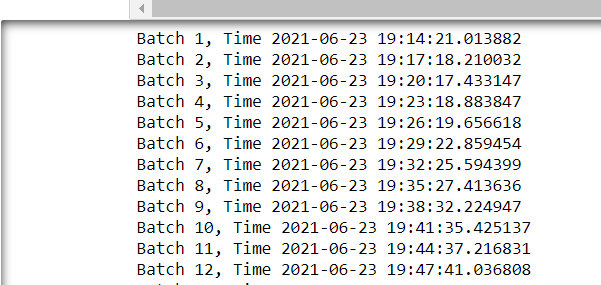

~4.7 million records took roughly 5 hours to parse and enter into the database.

# Database EDA

Here's a peek at the filled metadata table. This next section will focus on querying this database and graphing the resulting data to build a basic understanding of the dataset.

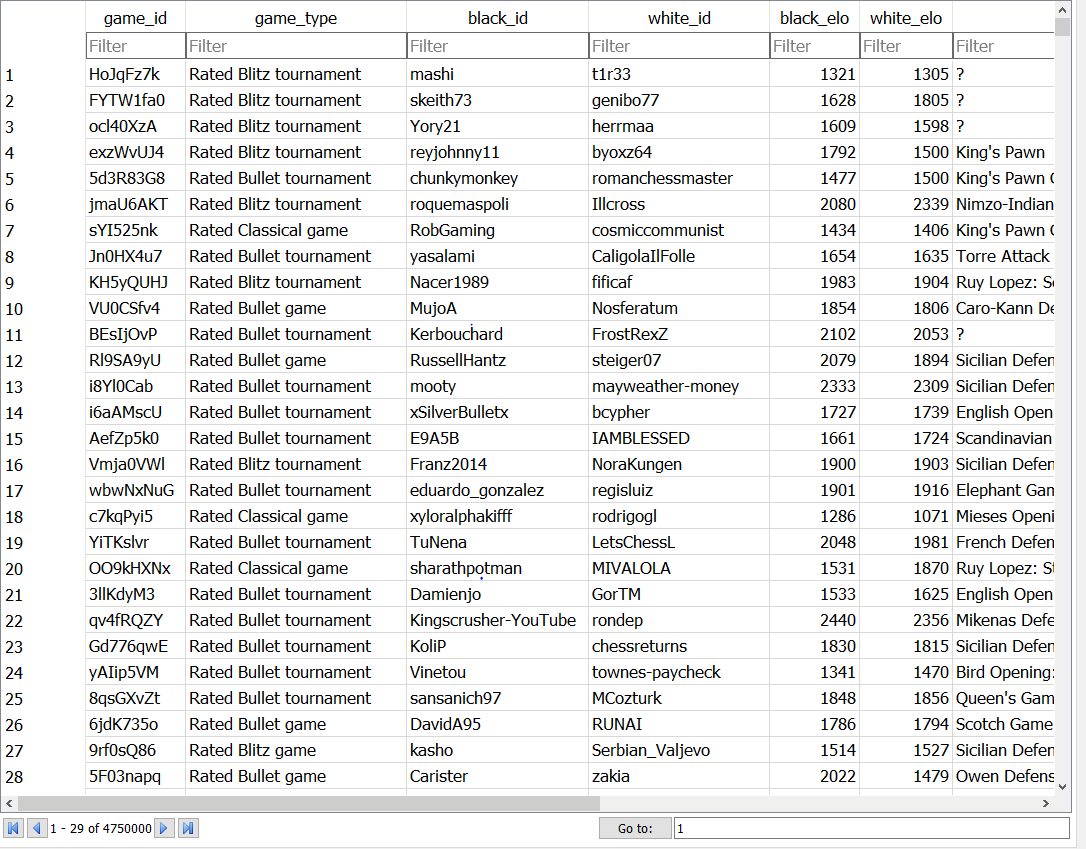




In [20]:
conn = sql.connect('lichess game data.db')
cur = conn.cursor()

Text(0.5, 1.0, 'Distribution of Game Types')

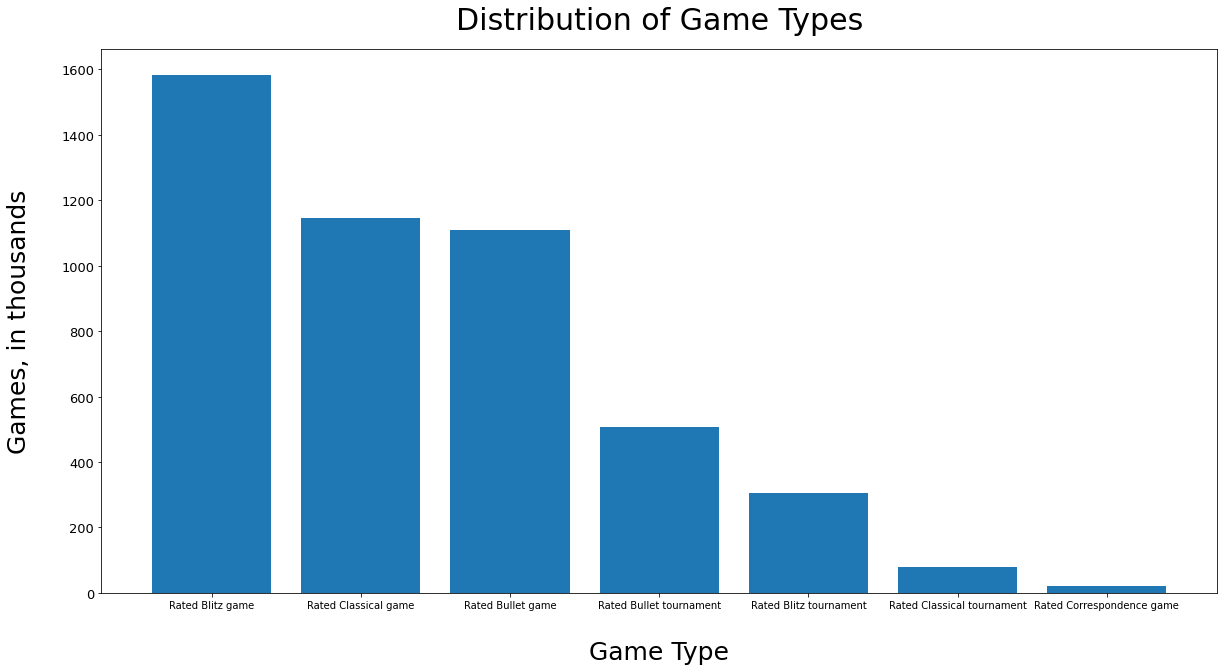

In [21]:
match_types = dict(cur.execute('''SELECT COUNT (game_id), game_type 
                    FROM games_metadata
                    GROUP BY game_type''').fetchall())

labels = []
for num in sorted(match_types.keys(), reverse=True):
    labels.append(match_types[num])

values = list(map(lambda x : x/1000, sorted(match_types.keys(), reverse=True)))

plt.figure(figsize=(20,10))
plt.bar(x=labels, height= values)

plt.xlabel('Game Type', fontsize=25, labelpad=30)
plt.xticks(fontsize=10)

plt.ylabel('Games, in thousands', fontsize=25, labelpad=30)
plt.yticks(fontsize=13)
plt.ticklabel_format(style='plain', axis='y')
plt.title('Distribution of Game Types', fontsize=30, pad=20)


Faster game styles dominate this dataset. This appears to be typical, based on other analysis projects.

In [23]:
win_breakdown = dict(cur.execute('''SELECT COUNT (game_id), winner 
                    FROM games_metadata
                    GROUP BY winner''').fetchall())

Text(0.5, 1.0, 'Who Wins, by Games')

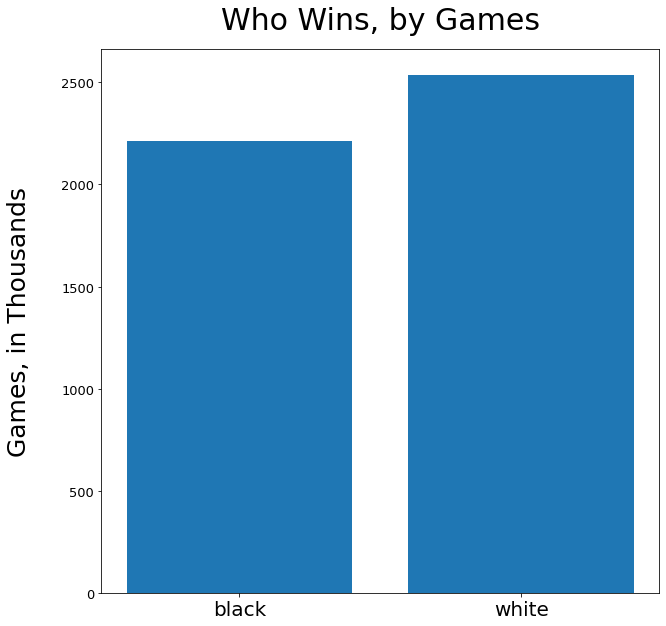

In [24]:
win_values = list(map(lambda x: x/1000, win_breakdown.keys()))

win_labels = win_breakdown.values()

plt.figure(figsize=(10,10))
plt.bar(x=win_labels, height= win_values)

plt.xticks(fontsize=20)

plt.yticks(fontsize=13)
plt.ylabel('Games, in Thousands', fontsize=25, labelpad=30)

plt.ticklabel_format(style='plain', axis='y')
plt.title('Who Wins, by Games', fontsize=30, pad=20)

Text(0.5, 1.0, 'Who Wins, by Percent')

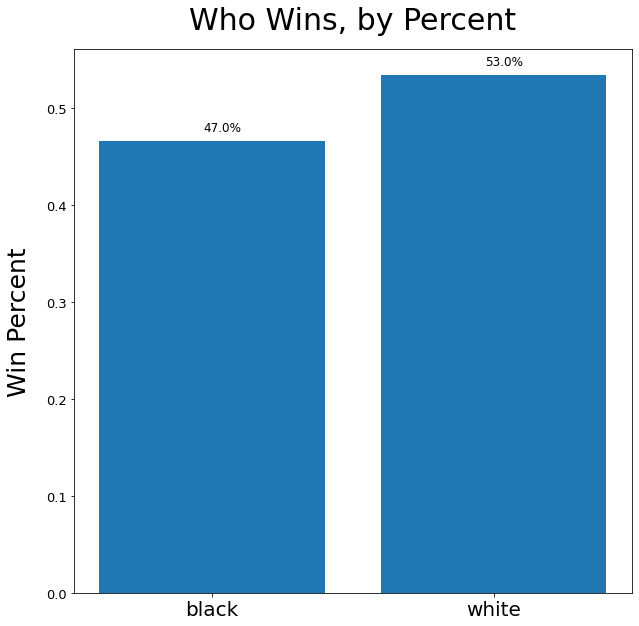

In [25]:
win_percent = {'black':list(win_breakdown.keys())[0] / sum(win_breakdown.keys()),
              'white': list(win_breakdown.keys())[1] / sum(win_breakdown.keys())}

plt.figure(figsize=(10,10))
plt.bar(x=win_percent.keys(), height= win_percent.values())

plt.xticks(fontsize=20)

plt.yticks(fontsize=13)
plt.ylabel('Win Percent', fontsize=25, labelpad=15)

for index, data in enumerate(win_percent.values()):
    plt.text(x=index-0.03, y=data+0.01, s=f"{round(data,2)*100}%", fontdict=dict(fontsize=12))

plt.ticklabel_format(style='plain', axis='y')
plt.title('Who Wins, by Percent', fontsize=30, pad=20)


As expected, white tends to win slightly more often than black

Text(0.5, 1.0, 'How Games End')

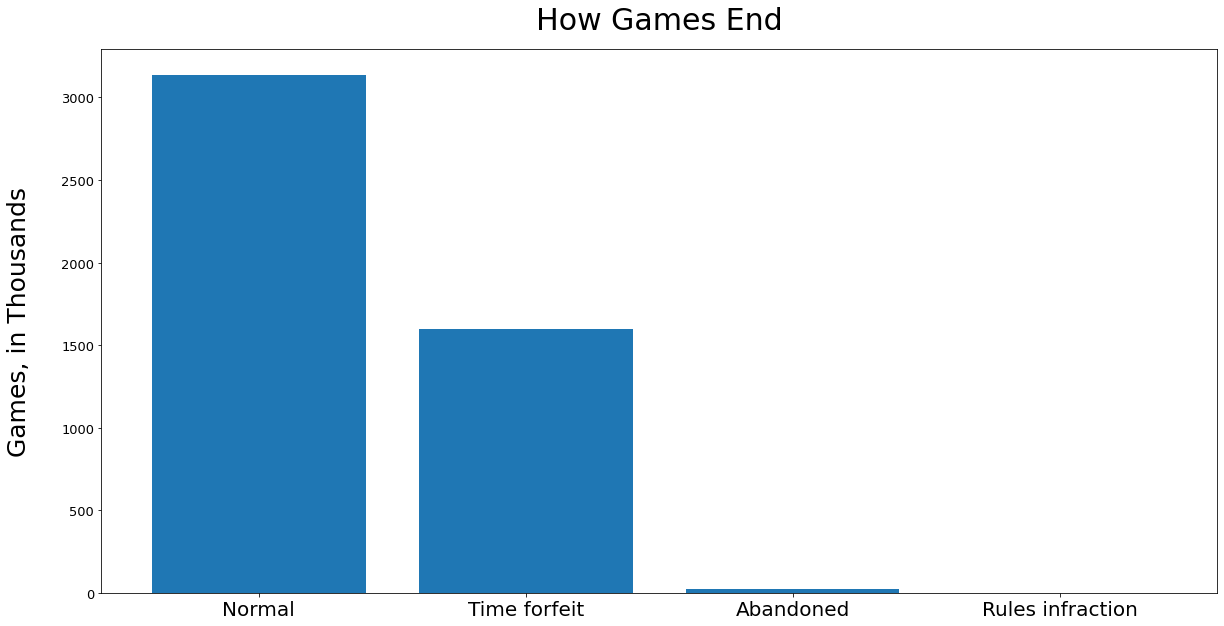

In [26]:
win_type = dict(cur.execute('''SELECT COUNT (game_id), game_end 
                    FROM games_metadata
                    GROUP BY game_end''').fetchall())

win_types_values = list(map(lambda x: x/1000, sorted(win_type.keys(), reverse=True)))

win_types_labels = []
for num in sorted(win_type.keys(), reverse=True):
    win_types_labels.append(win_type[num])

plt.figure(figsize=(20,10))
plt.bar(x=win_types_labels, height= win_types_values)

plt.xticks(fontsize=20)

plt.yticks(fontsize=13)
plt.ylabel('Games, in Thousands', fontsize=25, labelpad=30)

plt.ticklabel_format(style='plain', axis='y')
plt.title('How Games End', fontsize=30, pad=20)


I'm not sure how a game ends with a rules infraction in an online format. Anyhow, those games and 'abandoned' games may need to be culled from future analysis.

Text(0.5, 1.0, 'Black Elo Ratings, Per Game')

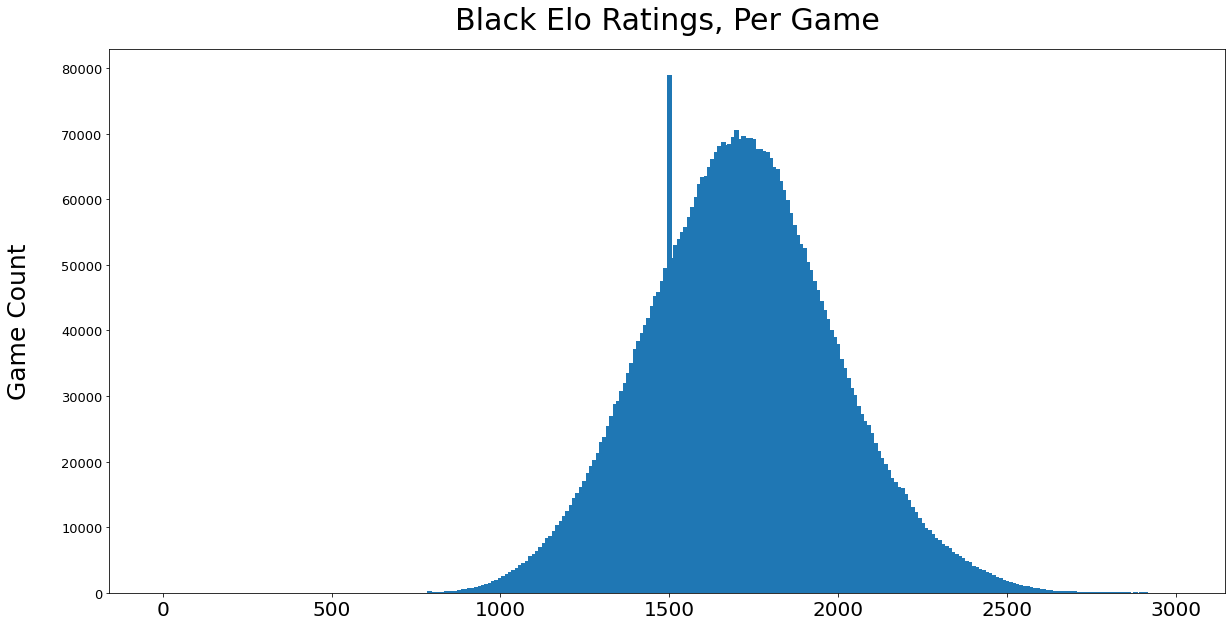

In [28]:
black_elos = dict((cur.execute('''SELECT ROUND(black_elo/10, 1)*10    AS bucket,
       COUNT(game_id)                    AS COUNT
FROM   games_metadata
GROUP  BY bucket''')).fetchall())

black_elos_values = list(black_elos.values())

black_elos_labels = list(black_elos.keys())

plt.figure(figsize=(20,10))
plt.bar(x=black_elos_labels, height= black_elos_values, width=15)

plt.xticks(fontsize=20)

plt.yticks(fontsize=13)
plt.ylabel('Game Count', fontsize=25, labelpad=30)

plt.ticklabel_format(style='plain', axis='y')
plt.title('Black Elo Ratings, Per Game', fontsize=30, pad=20)

Elo ratings of black side, in 10 point buckets. You can't see it here, but one quirk of the automated bucketing in SQL is that buckets with no data are excluded from the dataset. There's also that strange spike at 1500...

Text(0.5, 1.0, 'White Elo Ratings, Per Game')

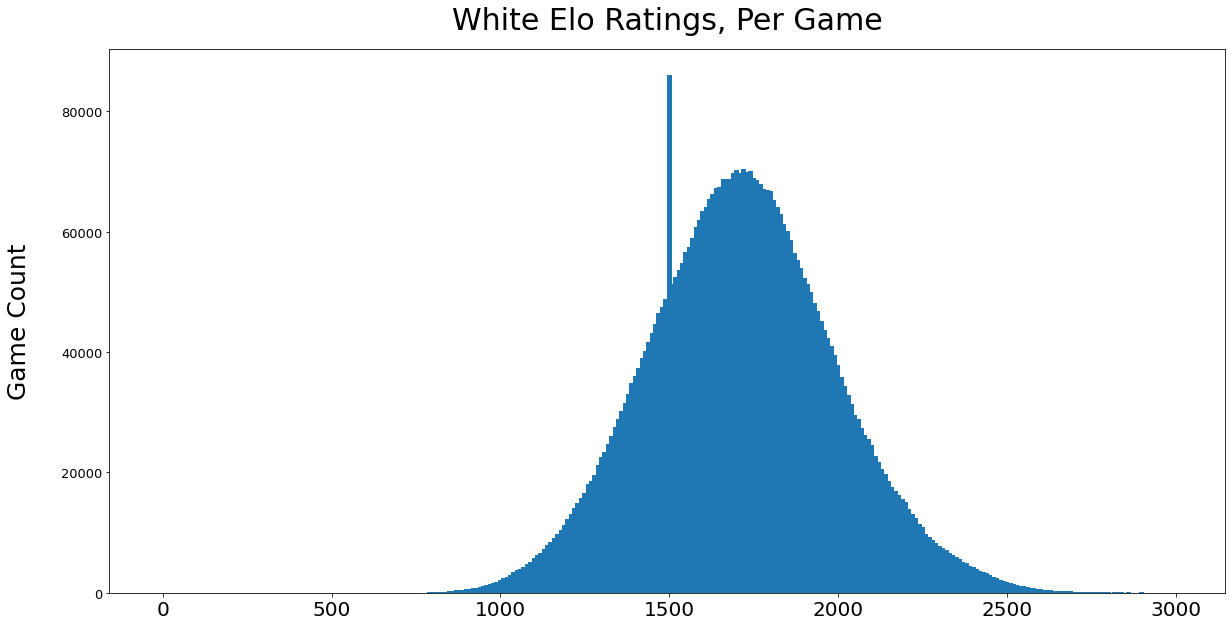

In [29]:
white_elos = dict((cur.execute('''SELECT ROUND(white_elo/10, 1)*10    AS bucket,
       COUNT(game_id)                    AS COUNT
FROM   games_metadata
GROUP  BY bucket''')).fetchall())

white_elos_values = list(white_elos.values())

white_elos_labels = list(white_elos.keys())

plt.figure(figsize=(20,10))
plt.bar(x=white_elos_labels, height= white_elos_values, width=15)

plt.xticks(fontsize=20)

plt.yticks(fontsize=13)
plt.ylabel('Game Count', fontsize=25, labelpad=30)

plt.ticklabel_format(style='plain', axis='y')
plt.title('White Elo Ratings, Per Game', fontsize=30, pad=20)

The white side has the same odd spike at 1500. We'll take a closer look shortly, but first lets see the ratings plotted together.

Text(0.5, 1.0, 'White & Black Elo Ratings, Per Game')

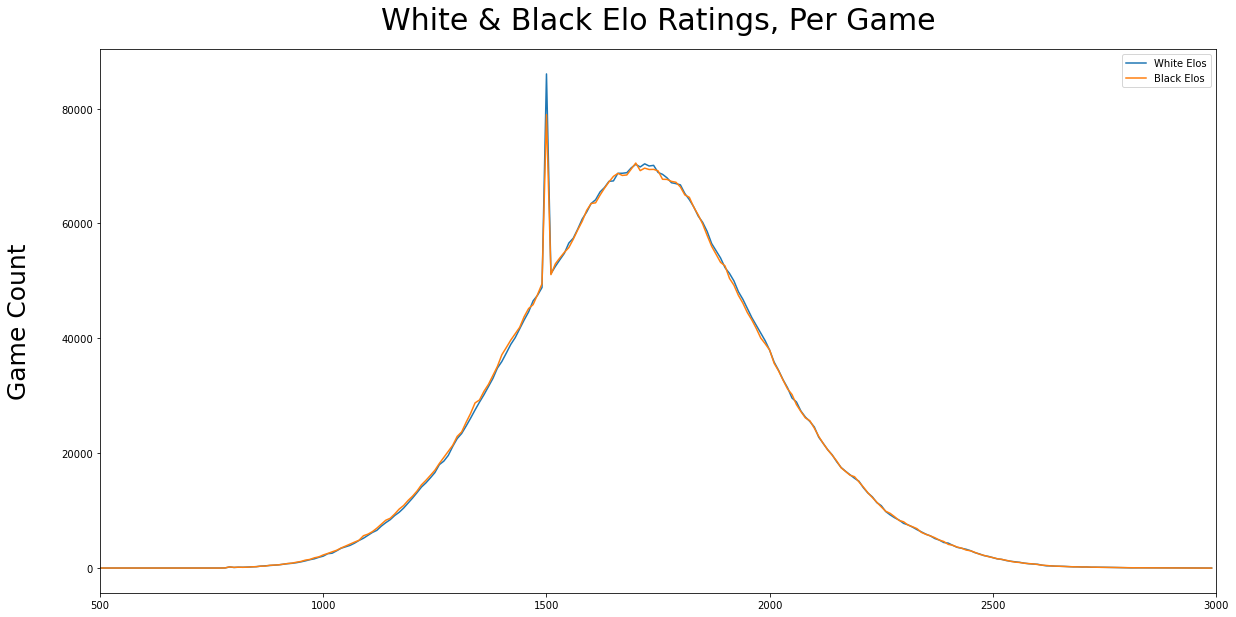

In [30]:
plt.figure(figsize=(20,10))
plt.xlim(left=500, right = 3000)

plt.plot(white_elos_labels, white_elos_values, label = 'White Elos')
plt.plot(black_elos_labels, black_elos_values, label = 'Black Elos')

plt.legend()
plt.ylabel('Game Count', fontsize=25, labelpad=30)
plt.title('White & Black Elo Ratings, Per Game', fontsize=30, pad=20)


As one would expect, the ratings line up pretty closely with one another, although the 1500 spike is a little higher for white players. The average looks to be in the 1700-1800 range, which is maybe a little higher than I would expect for the general public. These are Elo ratings by game however, not player. Let's take a look at player Elo ratings, by averaging all their games together.

In [32]:
w_elo_by_id = dict(cur.execute('''SELECT round(average/10)*10 AS bucket,
	count(white_id)
FROM(
	SELECT round(avg(white_elo)) as average, white_id
	FROM games_metadata
	GROUP BY white_id
	ORDER BY average DESC)
GROUP BY bucket;''').fetchall())

b_elo_by_id = dict(cur.execute('''SELECT round(average/10)*10 AS bucket,
	count(black_id)
FROM(
	SELECT round(avg(black_elo)) as average, black_id
	FROM games_metadata
	GROUP BY black_id
	ORDER BY average DESC)
GROUP BY bucket;''').fetchall())

Text(0.5, 1.0, 'Player Counts by Elo Rating')

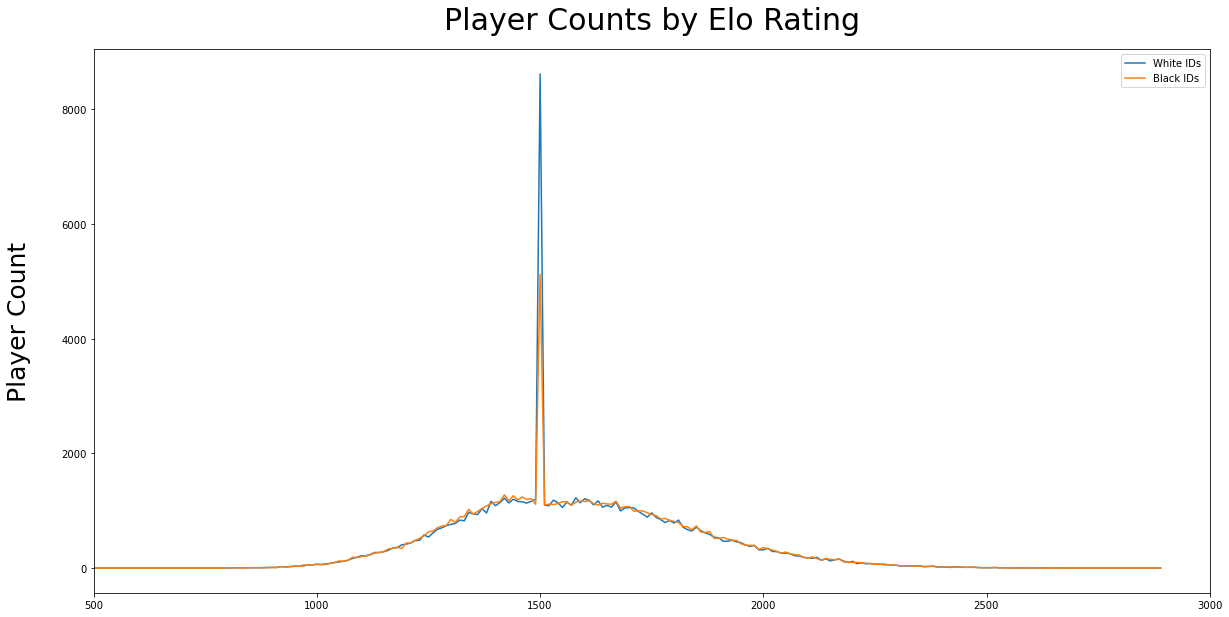

In [35]:
plt.figure(figsize=(20,10))
plt.xlim(left=500, right = 3000)

plt.plot(w_elo_by_id.keys(), w_elo_by_id.values(), label = 'White IDs')
plt.plot(b_elo_by_id.keys(), b_elo_by_id.values(), label = 'Black IDs')

plt.legend()
plt.ylabel('Player Count', fontsize=25, labelpad=30)
plt.title('Player Counts by Elo Rating', fontsize=30, pad=20)


These numbers look closer to what one would expect of a broad player base. That spike at 1500 looks even more suspicious though... let's dig into it.

Most likely what's happening is that players that are new to the Lichess system are arbitrarily assigned ratings of 1500. It's difficult to prove this directly with the available data, however there should be trends we can use to lend support to the idea. First, players that are new to the Lichess system are probably relatively inexperienced, or at least out of practice. If this is so, we should see players with exactly 1500 ratings lose relatively more often than expected. In addition, we can compile a list of all the players who played at least one game rated at 1500, and then see how many games those players played over the course of the month. If they are in fact newer players, it's reasonable to expect they play fewer games on average than people who played no games ranked at 1500. Of course, we have no way of distinguishing people who naturally arrived at a 1500 Elo versus those with an artifical rating, but the spike of games at 1500 is large enough that there's hope of seeing effects on aggregate stats anyway. 

Let's start by taking a look at win/loss ratios for games with at least one player rated at Elo 1500. Keep in mind when looking at this chart that we're analyzing the outcomes of games where the noted side's rating corresponds to the X values on the chart, and the difference in opponents Elo may be as large as -750 to +750 with regard to the player with the fixed rating.

In [39]:
white_rated_white_win = {}
white_rated_black_win = {}
black_rated_black_win = {}
black_rated_white_win = {}

for x in range (800, 2050, 50):
    
    #White rated as x and wins
    white_rated_white_win[str(x)] = cur.execute(F'''SELECT (cast(sum(white_winner) AS REAL) / count(game_id)) AS win_rate
    FROM(
        SELECT game_id, 
            CASE WHEN winner = 'white' THEN 1
            ELSE 0
            END white_winner
        FROM games_metadata
        WHERE white_elo ={x})''').fetchone()[0]
    
    #White rated as x and loses
    white_rated_black_win[str(x)] = cur.execute(F'''SELECT (cast(sum(black_winner) AS REAL) / count(game_id)) AS win_rate
    FROM(
        SELECT game_id, 
            CASE WHEN winner = 'black' THEN 1
            ELSE 0
            END black_winner
        FROM games_metadata
        WHERE white_elo ={x})''').fetchone()[0]
    
    #Black rated as x and wins
    black_rated_black_win[str(x)] = cur.execute(F'''SELECT (cast(sum(black_winner) AS REAL) / count(game_id)) AS win_rate
    FROM(
        SELECT game_id, 
            CASE WHEN winner = 'black' THEN 1
            ELSE 0
            END black_winner
        FROM games_metadata
        WHERE black_elo ={x})''').fetchone()[0]
    
    #Black rated as x and loses
    black_rated_white_win[str(x)] = cur.execute(F'''SELECT (cast(sum(white_winner) AS REAL) / count(game_id)) AS win_rate
    FROM(
        SELECT game_id, 
            CASE WHEN winner = 'white' THEN 1
            ELSE 0
            END white_winner
        FROM games_metadata
        WHERE black_elo ={x})''').fetchone()[0]
    


Text(0.5, 1.0, 'Win %, White Rated as X')

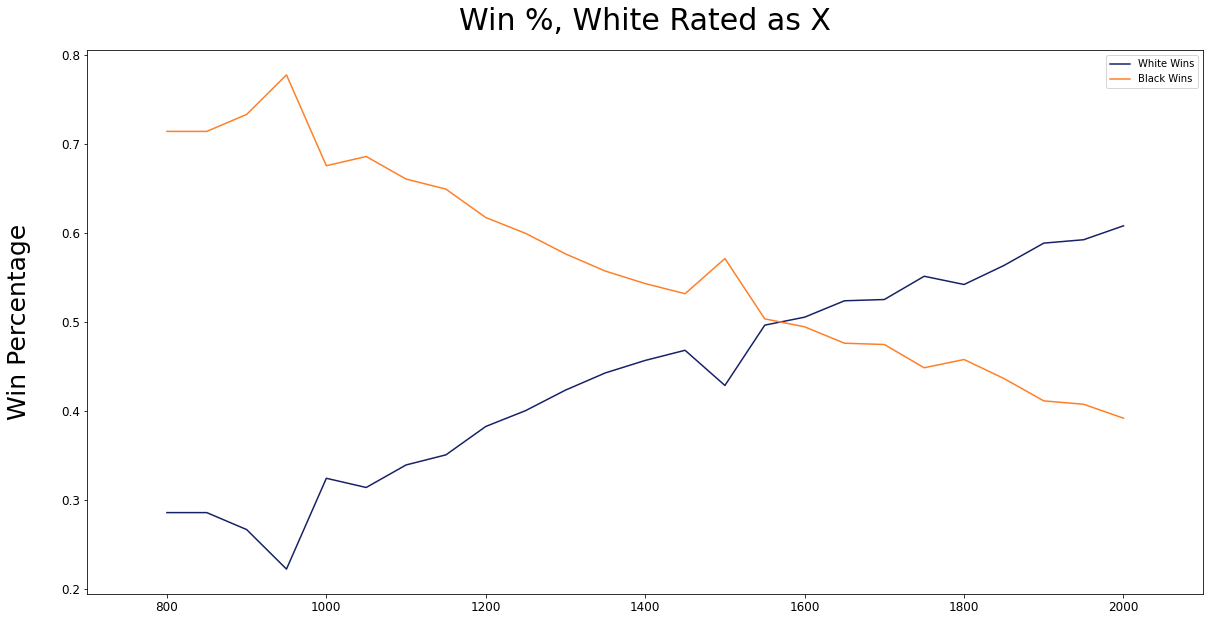

In [40]:
plt.figure(figsize=(20,10))
plt.xlim(left=700, right = 2100)

labels = list(map(int, white_rated_white_win.keys()))

plt.plot(labels, white_rated_white_win.values(), label='White Wins', color="#162166")
plt.plot(labels, white_rated_black_win.values(), label='Black Wins', color = '#ff7f26')
        
plt.legend()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('Win Percentage', fontsize=25, labelpad=30)
plt.title('Win %, White Rated as X', fontsize=30, pad=20)


Text(0.5, 1.0, 'Win %, Black Rated as X')

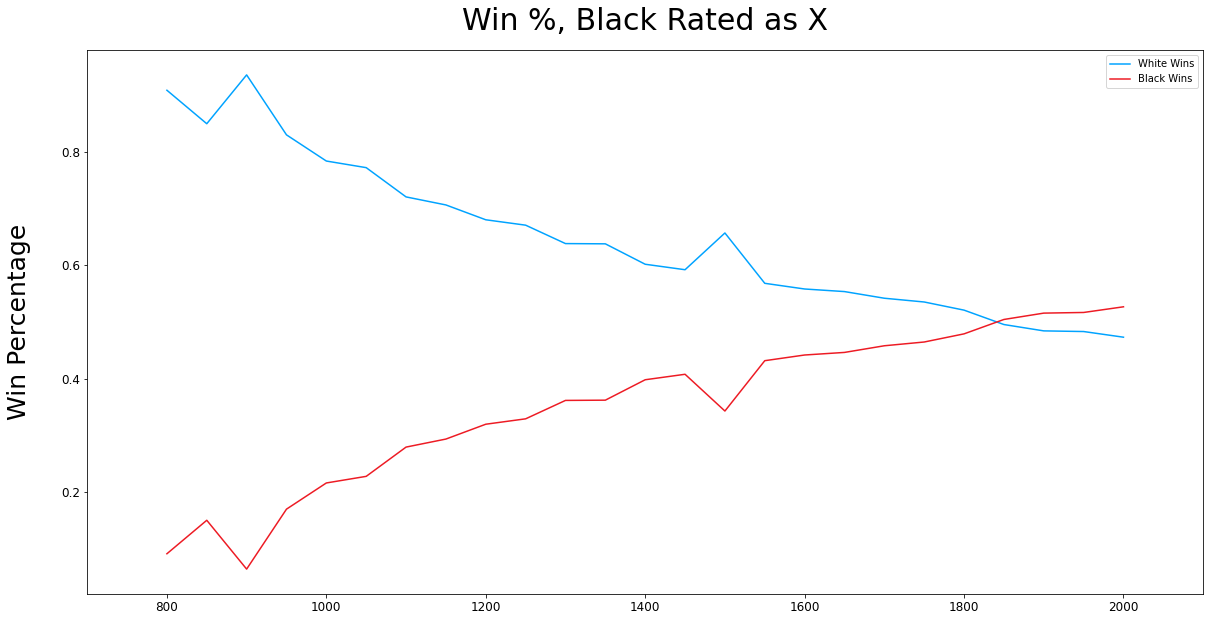

In [42]:
plt.figure(figsize=(20,10))
plt.xlim(left=700, right = 2100)

labels = list(map(int, black_rated_white_win.keys()))

plt.plot(labels, black_rated_white_win.values(), label='White Wins', color='#00a3ff')
plt.plot(labels, black_rated_black_win.values(), label='Black Wins', color='#ed1b24')
        
plt.legend()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('Win Percentage', fontsize=25, labelpad=30)
plt.title('Win %, Black Rated as X', fontsize=30, pad=20)

That is a rather distinctive deviation at Elo 1500 for both sides. Other than some sharp swings at lower ratings, the win rate is a pretty consistent function of Elo except for the 1500 rating. The deviation is also in the direction we would expect if the player has been rated artificially high, so there's pretty good support for the hypothesis so far.

Now, let's take a look at the average number of games played by player.

In [43]:
avg_games_broad = {}

for x in range (800, 2050, 50):
    avg_games_broad[str(x)] = cur.execute(F'''SELECT avg(games)
FROM(
	SELECT count() as games
	FROM games_metadata
	WHERE white_elo = {x}
	Group By white_id)''').fetchone()[0]
    
avg_games_narrow = {}
for x in range(1490,1511):
    avg_games_narrow[str(x)] = cur.execute(F'''SELECT avg(games)
FROM(
	SELECT count() as games, white_id
	FROM games_metadata
	WHERE white_elo = {x}
	Group By white_id)''').fetchone()[0]
    

Text(0.5, 1.0, 'Average Games Played By Players With One Game at Elo X')

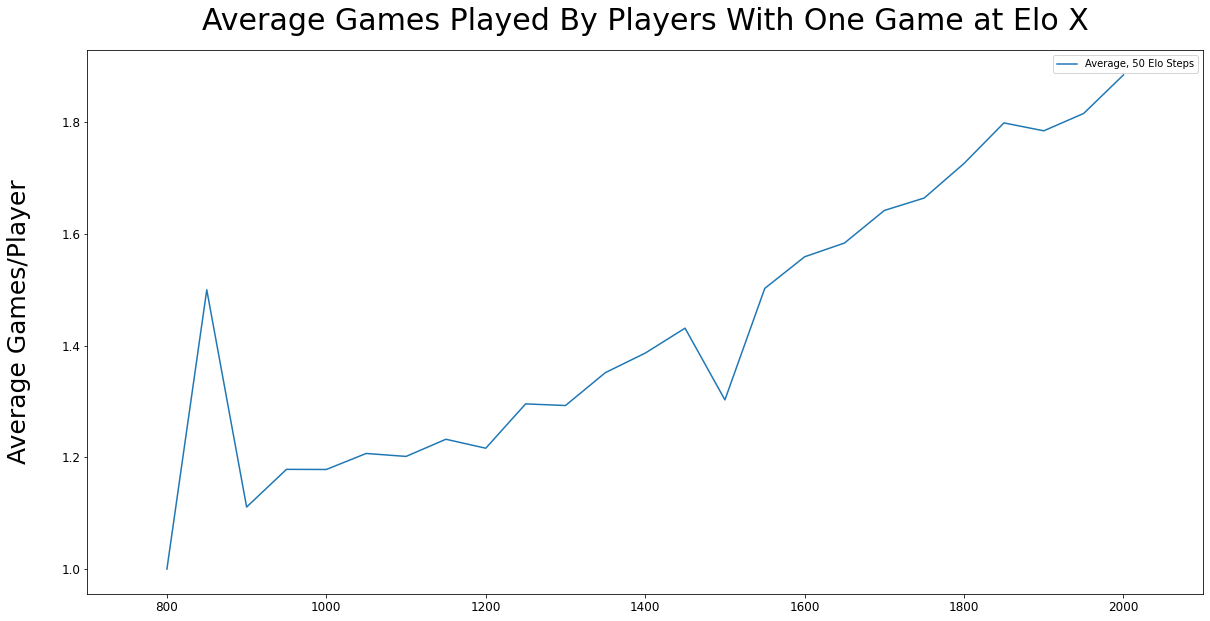

In [44]:
plt.figure(figsize=(20,10))
plt.xlim(left=700, right = 2100)

broad_labels = list(map(int, avg_games_broad.keys()))

plt.plot(broad_labels, avg_games_broad.values(), label='Average, 50 Elo Steps')
        
plt.legend()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('Average Games/Player', fontsize=25, labelpad=30)
plt.title('Average Games Played By Players With One Game at Elo X', fontsize=30, pad=20)

Text(0.5, 1.0, 'Average Games Played, Zoom on 1500')

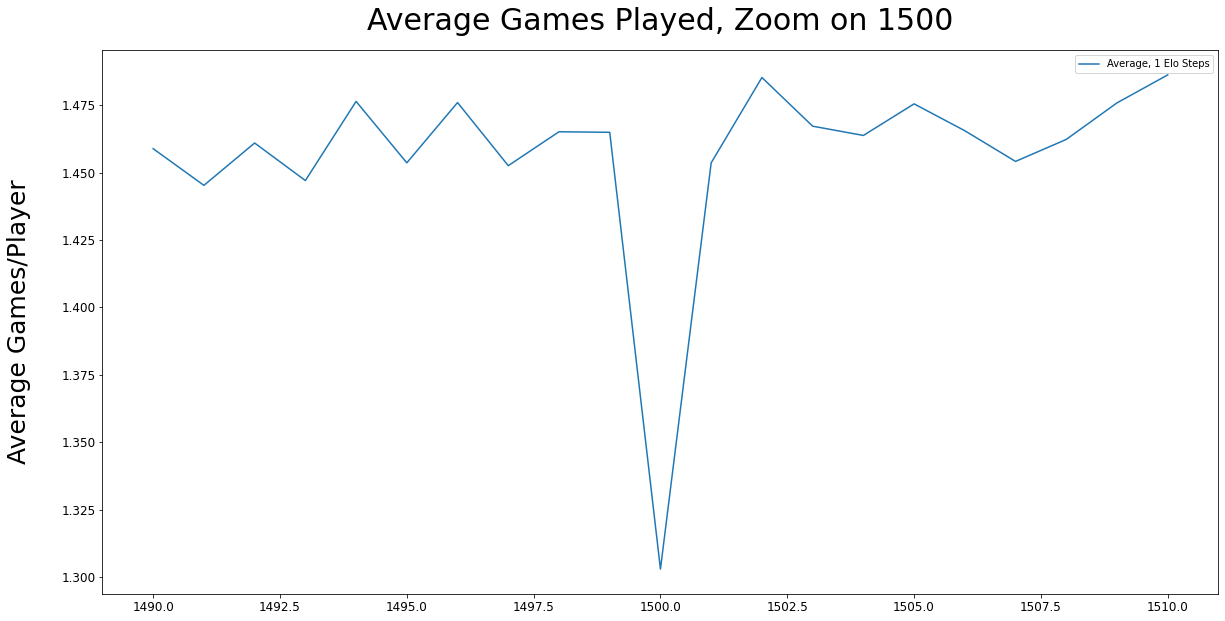

In [45]:
plt.figure(figsize=(20,10))

narrow_labels = list(map(int, avg_games_narrow.keys()))

plt.plot(narrow_labels, avg_games_narrow.values(), label='Average, 1 Elo Steps')
        
plt.legend()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('Average Games/Player', fontsize=25, labelpad=30)
plt.title('Average Games Played, Zoom on 1500', fontsize=30, pad=20)

These charts provide more support for the idea the 1500 rated players are new to the Lichess environment. The bulk change in average games per player is relatively small, only about 10%, but it's 10x larger than the average point to point change near 1500. 

So, it seems a safe bet that most players who were rated at 1500 at some point should actually be rated lower. We'll need to take that into account for the next steps of the analysis, as we're going to start looking at how players at different skill levels make use of their pieces.

# Game Analysis

Recall from earlier that we broke information about the games into metadata and game data. We're now going to dive into the game data. To do that, we'll need to write some code to retrieve that data from the database and parse it. We'll look at piece captures first.



In [58]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [59]:
pawns, rooks, knights, bishops, kings, queens = generate_pieces()
query_list = pawns + rooks + knights + bishops + kings + queens
backrow_query = rooks + knights + bishops + kings + queens

w_backrow = rooks[0:2] + knights[0:2] + bishops[0:2] + [queens[0]] + [kings[0]]
b_backrow = rooks[2:] + knights[2:] + bishops[2:] + [kings[1]] + [queens[1]]

In [ ]:
#Piece capping query loop
#We'll be breaking captures down based on total Elo of both players. Avg Elo would have worked as well.
#Note that captures are normalized by number of games in the query bucket
#This loop take a while to run.

elos = ['0','2500', '3000', '3500', '4000', '10000']
total_games = 0

for num in range(1,6):
    
    #Dict of dicts to track piece captures
    #Top level keys are used to accumulate captures of each piece
    #Second level keys will hold counts of how many times the level 2 piece capped the level 1 piece
    cap_dict = dict.fromkeys(query_list)
    for x in pawns[:8] + w_backrow:
        cap_dict[x] = dict.fromkeys(pawns[8:] + b_backrow)
    for x in (pawns[8:] + b_backrow):
        cap_dict[x] = dict.fromkeys(pawns[:8] + w_backrow)
    
    
    lower = elos[num-1]
    upper = elos[num]
    
    games_num = (len(cur.execute(F'''SELECT p1
            FROM(
                SELECT moves_by_piece.p1
                FROM(
                    SELECT game_id, number_of_moves
                    FROM games_metadata
                    WHERE (games_metadata.elo_sum >= {lower} AND games_metadata.elo_sum <{upper})) AS ELO
                JOIN moves_by_piece
                ON moves_by_piece.game_id = ELO.game_id
                WHERE ELO.number_of_moves > 2);''').fetchall()
                    )
                    )
    
    total_games += games_num
    print(total_games)
    
    for capped_piece in cap_dict.keys():
        print(F'{capped_piece} Batch @ ', dt.datetime.now())

        for capping_piece in cap_dict[capped_piece].keys():
            cap_dict[capped_piece][capping_piece] = (len(cur.execute(F'''SELECT {capped_piece}
            FROM(
                SELECT moves_by_piece.{capped_piece}
                FROM(
                    SELECT game_id, number_of_moves
                    FROM games_metadata
                    WHERE (games_metadata.elo_sum >= {lower} AND games_metadata.elo_sum < {upper})) AS ELO
                JOIN moves_by_piece
                ON moves_by_piece.game_id = ELO.game_id
                WHERE ELO.number_of_moves > 2)
            WHERE {capped_piece} LIKE '%{capping_piece}';''')
                                                         .fetchall()
                                                        ) / games_num
                                                        )
    save = json.dumps(cap_dict)

    #Save the results in a text file for later analysis
    with open(F'''query results\cap_dict_elosum_{lower}-{upper}.txt''', 'w') as new_file:
        new_file.write(save)
        
    cap_dict.clear()
    print(total_games)

Here's a snip of the status reports for the query loop. The whole process took a little over 10 hours.

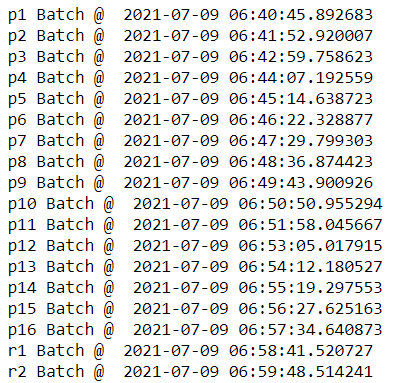

Queries run and results saved, next is visualizing the piece captures. Let's see what a heatmap and sankey plot look like.

In [67]:
def generate_piece_key():
    '''For df replacement'''
    
    pawns, rooks, knights, bishops, kings, queens = generate_pieces()
    piece_list = pawns + rooks + knights + bishops + kings + queens + ['Pawns'] + ['Rooks'] + ['Knights'] + ['Bishops'] + ['All Captures']
    piece_key = dict(zip(piece_list, range(37)))
    
    return piece_key

def piece_labels():
    '''For use with Sankey plot'''
    
    labels = [0] * 36
    x = ['H', 'G', 'F', 'E', 'D', 'C', 'B', 'A']
    
    for i in range(8,16):
        labels[i] = x[i-8] + ' Pawn'

    x.reverse()

    for i in range(8):
        labels[i] = x[i] + ' Pawn'

    labels[16:20] = ['A Rook', 'H Rook', 'H Rook', 'A Rook']
    labels[20:24] = ['B Knight', 'G Knight', 'G Knight', 'B Knight']
    labels[24:28] = ['Dark Bishop', 'Light Bishop', 'Light Bishop', 'Dark Bishop']
    labels[28:30] = ['King', 'King']
    labels[30:32] = ['Queen', 'Queen']
    labels[32:37] = ['Pawns','Rooks','Knights','Bishops','All Captures']
    
    return tuple(labels)

def df_prep(df, filter_list):
    '''Basic filtering and cleaning function to prep for Sankey and Heatmap figure generation. Returns df'''
    
    stack_df = df.filter(items=filter_list, axis=0)
    stack_df = pd.DataFrame(stack_df.dropna(axis=1).stack())
    
    stack_df.reset_index(inplace=True)
    
    cols = dict(zip(['level_0', 'level_1', 0],['Source', 'Target', 'Value']))
    stack_df.rename(columns = cols, inplace=True)
    
    return stack_df

def generate_sankey_plot(df, filter_list):
    '''Takes in DataFrame generated from capture queries, filters by color then cleans & preps for Sankey visuals.
    Returns Plotly object.'''
    
    
    labels = piece_labels()
    piece_key = generate_piece_key()
    
    sankey_df = df_prep(df, filter_list)
    
    sankey_df.replace(to_replace=piece_key, inplace=True)
    
    sankey_df = pd.DataFrame(sankey_df.groupby('Source').sum())
    sankey_df.reset_index(inplace = True)
    
    new_cols = dict(zip(sankey_df.columns, ['Target', 'Source', 'Value']))
    sankey_df.rename(columns = new_cols, inplace=True)
    
    sankey_df.loc[sankey_df['Target'] < 16, 'Source'] = piece_key['Pawns']
    sankey_df.loc[(sankey_df['Target'] < 20) & (sankey_df['Target'] > 15), 'Source'] = piece_key['Rooks']
    sankey_df.loc[(sankey_df['Target'] < 24) & (sankey_df['Target'] > 19), 'Source'] = piece_key['Knights']
    sankey_df.loc[(sankey_df['Target'] < 28) & (sankey_df['Target'] > 23), 'Source'] = piece_key['Bishops']
    sankey_df.loc[(sankey_df['Target'] < 32) & (sankey_df['Target'] > 27), 'Source'] = piece_key['All Captures']
    
    for source in range(32, 36):
        total = sankey_df[sankey_df['Source'] == source]['Value'].sum()
        record = {'Target':source, 'Source':36, 'Value':total}
        sankey_df = sankey_df.append(record, ignore_index=True)
        
    source = list(sankey_df['Source'])
    target = list(sankey_df['Target'])
    value = list(sankey_df['Value'])
    
    link = (dict(source=source, 
             target=target, 
             value=value))
    
    node = dict(label = labels)
    data = go.Sankey(link=link, node=node)
    fig = go.Figure(data)
    
    return fig

def generate_heatmap(df, filter_list):
    '''Takes in DataFrame generated from capture queries, filters by color then cleans & preps for Sankey visuals.
    Returns Plotly object.'''
    
    pawns, rooks, knights, bishops, kings, queens = generate_pieces()
    
    x= ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
    y = ['1', '2', '3', '4', '5', '6', '7', '8']
    
    if 'k1' in filter_list:
        pieces = ([rooks[0]] + [knights[0]] + [bishops[0]] + [queens[0]] +
                  [kings[0]] + [bishops[1]] + [knights[1]] + [rooks[1]] + pawns[:8]
                 )
    if 'k2' in filter_list:
        pieces = ([rooks[2]] + [knights[2]] + [bishops[2]] + [kings[1]] + 
                  [queens[1]] + [bishops[3]] + [knights[3]] + [rooks[3]] + pawns[8:]
                 )
        x.reverse()
        y.reverse()
    
    
    heatmap = df_prep(df, filter_list)
    heatmap = pd.DataFrame(heatmap.groupby('Source').sum())
    
    
    hm_data = []
    for p in pieces:
        hm_data.append(heatmap['Value'][p])
    hm_data = [hm_data[:8]]+[hm_data[8:]]
    hm_data += [[0]*8]*6

    fig = go.Heatmap(z=hm_data, x=x, y=y, xgap=1, ygap=1)

    return fig

In [68]:
pawns, rooks, knights, bishops, kings, queens = generate_pieces()

w_filter = rooks[0:2] + knights[0:2] + bishops[0:2] + [queens[0]] + [kings[0]] + pawns[:8]
b_filter = rooks[2:] + knights[2:] + bishops[2:] + [kings[1]] + [queens[1]] + pawns[8:]

overall = pd.read_json('query results\cap_dict.txt')
twentyfive = pd.read_json('query results\cap_dict_elosum_0-2500.txt')
three = pd.read_json('query results\cap_dict_elosum_2500-3000.txt')
thirtyfive = pd.read_json('query results\cap_dict_elosum_3000-3500.txt')
four = pd.read_json('query results\cap_dict_elosum_3500-4000.txt')
ten = pd.read_json('query results\cap_dict_elosum_4000-10000.txt')

overall = generate_heatmap(overall, w_filter)
twentyfive = generate_heatmap(twentyfive, w_filter)
three = generate_heatmap(three, w_filter)
thirtyfive = generate_heatmap(thirtyfive, w_filter)
four = generate_heatmap(four, w_filter)
ten = generate_heatmap(ten, w_filter)

row1 = [overall, twentyfive, three]
row2 = [thirtyfive, four, ten]

fig = make_subplots(rows=2, cols=3)

fig.add_traces(row1, rows=1, cols=[1,2,3])
fig.add_traces(row2, rows=2, cols=[1,2,3])
fig.update_traces(zmin=0, zmax=1.3)
fig.update_layout(height=750, width = 1000)